## Getting started

- Run first cell with either `load_hamburg_netatmo_data()` or `load_stuttgart_sensor_community_data()` and assign qc_gdf, m5_gdf, rest_gdf. m5 means m5 level of QC. this could also be adapted to only check up to the m4 level
(make sure to use the correct crs for plotting, idk why they are not the same)
- if you need to create the 50 neighbour testsets for each sensor, run the Dataset Creation for ML cell. You can also adjust the nearest neighbour count. The created dataset has the first column the target variable of the sensor itself by sensor id and timestamp, then the neighbour columns and then afterwards feature columns. Currently the time is the only feature (with a really small influence, like 0.03 on the final result) (depending on the amount of sensors and number of neighbours can take over 180 min per provider)
- after creating the testsets, run the ML Model Eval to create a eval_df that includes the information about each model, that can be plotted afterwards. This step can take very long, e.g. over 240 min, so make sure to save the eval_df to csv to load it instantly and make sure to not override an existing eval_df accidentally
- profit

# Helper methods - run first

In [31]:
from scipy.spatial import KDTree
import pandas as pd
import geopandas as gpd
from pytz import UTC
import numpy as np
import contextily as ctx
import matplotlib.pyplot as plt
from typing import Union
import numpy.typing as npt
from typing import List, Tuple
import seaborn as sns
from shapely.geometry import Point, box
from matplotlib.lines import Line2D
from geopandas.tools import sjoin, sjoin_nearest
from scipy.spatial import KDTree
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer
from sklearn.inspection import permutation_importance

# Ignore divide by NaN warnings for normalisation from StandardScaler
np.seterr(divide='ignore', invalid='ignore')

# set print options
np.set_printoptions(linewidth=110)
pd.set_option('display.width', 200)
plt.style.use('bmh')  # better for plotting geometries vs general plots.

start = pd.Timestamp('2023-06-01 01:00:00', tz=UTC)
end = start + pd.Timedelta(days=30)
crs = 4326

def create_dataset_for_sensor_id(start, end, neighbours_gdf, sensor_id, freq, provider, nn_count, path, min_values=10, save=True, features: Union[str, List[str], None] = None, use_p_id_labels: bool = False, neighbour_ids: Union["pd.Series[str]", "pd.Series[int]", None] = None) -> pd.DataFrame :
    """
    Creates X and y datasets for a given sensor id.

    Parameters
    ----------
    start : pd.Timestamp
        The start time of the dataset
    end : pd.Timestamp
        The end time of the dataset
    neighbours_gdf : geopandas.GeoDataFrame
        The dataframe with the neighbours
    sensor_id : str
        The sensor id
    freq : int
        The frequency of the dataset in minutes
    provider : str
        The provider of the data
    nn_count : int
        The number of nearest neighbours to include
    path : str
        The path to save the dataset to
    min_values : int
        The minimum number of values in the dataset
    save : bool
        Whether to save the dataset to a file
    features : numpy.ndarray
        The features to include in the dataset. Can be None, "time", "humidity", "pressure",  a combination of those or "all" for all features.
    use_p_id_labels : bool
        If set to false, the p_ids of the neigbours are replaced with integer labels ordered by ascending distance. If set to true, the p_ids are used as labels based on feature: {feature}_{p_id}.
    neighbour_ids : list of str
        A list of p_ids to include in the dataset. The order of the ids is used as the label for the neighbours, e.g. the first neighbour is labelled with 1, and the columns are called ta_1, etc. If None, the ids of nn_count neigbours are used ordered by distance ascending. The sensor_id is always included.

    Information
    -------
    features:
        time: The time of day as a continuous value. The timestamp needs to be in the column 'time'. This column is only added once to the dataset.
        humidity: The humidity of the sensor. The humidity needs to be in the column 'humidity'. This column is added nn_count times to the dataset, once for each neighbour. If the value is missing, it is replaced with NaN.
        pressure: The pressure of the sensor. The pressure needs to be in the column 'pressure'. This column is added nn_count times to the dataset, once for each neighbour. If the value is missing, it is replaced with NaN.

    """

    X_data = []

    neighbours_gdf = neighbours_gdf.sort_values(by=['distance'])

    if neighbour_ids is None:
        neighbour_ids = pd.Series(neighbours_gdf['p_id'].unique()[0:nn_count + 1])

    for date in pd.date_range(start=start, end=end, freq=f'{freq}min'):
        start_time = date.to_datetime64()
        end_time = start_time + pd.Timedelta(minutes=freq)

        filtered_gdf = neighbours_gdf.copy()
        filtered_gdf = filtered_gdf[(filtered_gdf['time'] >= start_time) & (filtered_gdf['time'] < end_time)]
        filtered_gdf.set_index('p_id', inplace=True)

        if filtered_gdf.empty:
            continue

        feature_values = []

        if features is not None:
            if features == "all":
                features = ["time", "humidity", "pressure"]
            for feature in features:
                if feature == "time":
                    # Convert time to time of day
                    filtered_gdf['time'] = filtered_gdf['time'].apply(lambda x: (x.hour * 60 + x.minute) * 2 * np.pi / (24 * 60))
                    filtered_gdf.rename(columns={'time': 'time_angle'}, inplace=True)

                    # Calculate continuous representation of time as an angle in radians
                    filtered_gdf['sin_time'] = np.sin(filtered_gdf['time_angle'])
                    # First is y, then nn_count ta, then features
                    feature_values.append(filtered_gdf['sin_time'].values[0])
                if feature == "humidity":
                    for index, p_id in neighbour_ids.items():
                        if p_id in filtered_gdf.index:
                            feature_values.append(filtered_gdf.loc[p_id].humidity)
                        else:
                            feature_values.append(np.nan)
                if feature == "pressure":
                    for index, p_id in neighbour_ids.items():
                        if p_id in filtered_gdf.index:
                            feature_values.append(filtered_gdf.loc[p_id].pressure)
                        else:
                            feature_values.append(np.nan)

        feature_count = len(feature_values)
        column_count = 1 + nn_count + feature_count
        x = np.full(column_count, np.nan, dtype=object)
        x = np.append(x, feature_values)

        columns = ['y']

        if use_p_id_labels:
            columns.extend(['ta_' + neighbour_ids[i] for i in range(1, nn_count + 1)])
        else:
            columns.extend(['ta_' + str(i) for i in range(1, nn_count + 1)])

        # TODO: add correct feature names
        columns.extend(['feature_' + str(i) for i in range(1, feature_count + 1)])

        # neighbours need to be ordered by distance, so closest neighbour is first.
        # each p_id should only occur once in the filtered dataframe.
        for index, p_id in neighbour_ids.items():
            if p_id in filtered_gdf.index:
                ta_values = filtered_gdf.loc[p_id].ta

                if isinstance(ta_values, pd.Series):
                    x[index] = ta_values.values.mean()
                elif isinstance(ta_values, float):
                    x[index] = ta_values
                else:
                    raise Exception(f'Invalid type for ta_values: {type(ta_values)}')

        # Skip if the target value is missing
        if np.isnan(x[0]):
            continue

        new = pd.DataFrame([x], columns=columns)

        if new.y.isnull().values.any():
            print(f'NaN values in dataset for sensor {sensor_id} with {len(new.values)} entries')
    
        X_data.append(new)
    
    if len(X_data) == 0:
        print(f'No data for sensor {sensor_id} with {len(X_data)} entries')
        return
    
    if len(X_data) < min_values:
        print(f'Not enough data for sensor {sensor_id} with {len(X_data)} entries')
        return

    X = pd.concat(X_data, axis=0, ignore_index=True)
    
    if save:
        file_name = f'./data/testsets/{path}/{provider}/{sensor_id}_dataset.csv'
        print(f'Saving dataset for sensor {sensor_id} with {len(X.values)} entries to {file_name}')

        X.to_csv(file_name, index=False)
        
    return X

def get_neighbour_distances_from_coords(coords: tuple, tree: KDTree, nn_count: int = 11):
    """
    Returns a dataframe with the distances to k-nearest neighbours in km (approximated).

    Parameters
    ----------
    coords : tuple of longitude and latitude
        The coordinates to find the nearest neighbours for
    tree : scipy.spatial.KDTree
        The tree to query
    nn_count : int
        The number of nearest neighbours to find
    """

    dist, idx = tree.query(coords, k=nn_count + 1, p=2)

    idx = idx[0]
    # Multiply each distance by 111 to roughly get km from lon/lat euclidean distance.
    dist = dist[0] * 111
    distance_df = pd.DataFrame(zip(idx, dist), columns=["index", "distance"])
    distance_df.set_index("index", inplace=True)
    return distance_df

def create_neighbour_df(tree: KDTree, coords: tuple, p_ids_df: pd.DataFrame, parent_gdf: gpd.GeoDataFrame, target_p_id: Union[str, None] = None, nn_count: int = 11, min_distance: float=0.0, simulated_sensors: Union[dict, None] = None, neighbour_ids: Union[List[str], None] = None) -> Union[gpd.GeoDataFrame, None]:
    """
    Returns a dataframe with all rows from parent_gdf whose p_id is in k-nearest neighbours to a given point with a minimum distance.
    The closest point to the coordinates is the target station and is included in the dataframe.

    Parameters
    ----------
    tree : scipy.spatial.KDTree
        The tree to query
    coords : tuple of longitude and latitude
        The coordinates to find the nearest neighbours for
    p_ids_df : pandas.DataFrame
        A dataframe with the p_ids of the parent_gdf
    nn_count : int
        The number of nearest neighbours to find. If neighbour_ids is set, this is ignored.
    p_ids_df : pandas.DataFrame
        A dataframe with the p_ids of the parent_gdf
    parent_gdf : geopandas.GeoDataFrame
        The dataframe to filter
    min_distance : float
        The minimum distance to the target station
    simulated_sensors : dict
        A dictionary with p_ids as keys and the number of samples to simulate as values. If the value is an int, the number of samples taken from the dataframe with that p_id. If the value is a string, the dataframe is resampled with the given string as frequency, with the first value being taken. If the value is None, the p_id is completely removed from the dataframe.
    neighbour_ids : list of str
        A list of p_ids to include in the dataframe. If None, all nn_count neigbours are included. The target_p_id is always included. If set, only the p_ids in the list are included and the nn_count is ignored.
    """

    distance_df = get_neighbour_distances_from_coords(coords, tree, 150)

    nearest_df = distance_df.join(p_ids_df, how="inner")
    nearest_df.sort_values(by=['distance'], inplace=True)

    # Filter out neighbours that are too close
    min_distance_gdf = nearest_df[nearest_df['distance'] > min_distance]
    neighbours_gdf = parent_gdf.copy()

    if neighbour_ids is None:
        neighbour_ids = min_distance_gdf['p_id'].unique()[1:nn_count + 1]

    if target_p_id is None:
        neighbours_gdf = parent_gdf[(parent_gdf['p_id'].isin(neighbour_ids))]
    else:
        neighbours_gdf = parent_gdf[(parent_gdf['p_id'].isin(neighbour_ids)) | (parent_gdf['p_id'] == target_p_id)]

    # Add distance column
    neighbours_gdf = neighbours_gdf.merge(nearest_df, on='p_id', how='inner', suffixes=('', '_right'))
    neighbours_gdf.drop(columns=['geometry_right'], inplace=True)

    # Resample certain p_ids to simulate missing data
    if simulated_sensors is not None:
        for p_id, sample_setting in simulated_sensors.items():
            if p_id in neighbours_gdf['p_id'].values:
                # If set to all, keep all samples
                if sample_setting is not None and isinstance(sample_setting, str) and sample_setting.lower() == "all":
                    continue

                p_id_df = neighbours_gdf[neighbours_gdf['p_id'] == p_id]

                if isinstance(sample_setting, int):
                    # Make sure to not draw more samples than there are
                    if len(p_id_df) < sample_setting:
                        sample_setting = len(p_id_df)
                        print(f'Warning: Not enough samples for p_id {p_id}, using {sample_setting} samples instead')

                    p_id_df = p_id_df.sample(n=sample_setting, replace=False, random_state=42)
                elif isinstance(sample_setting, str):
                    # Todo: Not working as expected
                    p_id_df = p_id_df.resample(sample_setting, on='time').first()
                elif sample_setting is None:
                    neighbours_gdf = neighbours_gdf[neighbours_gdf['p_id'] != p_id]
                    continue
                else:
                    raise Exception(f'Invalid sample setting: {sample_setting}')
                
                neighbours_gdf = neighbours_gdf[neighbours_gdf['p_id'] != p_id]
                neighbours_gdf = pd.concat([neighbours_gdf, p_id_df])

    return neighbours_gdf

def plot_neighbours_min_distance(crs, gdf_nearest, target_p_id, zoom='auto'):
    fig, ax = plt.subplots(figsize=(10,10))

    # gdf_nearest.plot(ax=ax)
    target_df = gdf_nearest[gdf_nearest['p_id'] == target_p_id]
    # min_distance_gdf.plot(ax=ax)

    gdf_nearest.plot(marker='o', ax=ax, markersize=15, column='distance', legend=True)
    target_df.plot(marker='x', ax=ax, markersize=30, color='#e41a1c')
    # ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.05))

    # zoom = ctx.tile._calculate_zoom(*gdf_nearest.total_bounds)
    ctx.add_basemap(
        ax,
        crs=crs,
        zoom=zoom,
        alpha=0.7,
        source=ctx.providers.Stamen.TonerLines
    )

    return fig, ax

# Helpers

from matplotlib.patches import PathPatch

def adjust_box_widths(g, fac):
    """
    Adjust the withs of a seaborn-generated boxplot.
    """

    # iterating through Axes instances
    for ax in g.axes:

        # iterating through axes artists:
        for c in ax.get_children():

            # searching for PathPatches
            if isinstance(c, PathPatch):
                # getting current width of box:
                p = c.get_path()
                verts = p.vertices
                verts_sub = verts[:-1]
                xmin = np.min(verts_sub[:, 0])
                xmax = np.max(verts_sub[:, 0])
                xmid = 0.5*(xmin+xmax)
                xhalf = 0.5*(xmax - xmin)

                # setting new width of box
                xmin_new = xmid-fac*xhalf
                xmax_new = xmid+fac*xhalf
                verts_sub[verts_sub[:, 0] == xmin, 0] = xmin_new
                verts_sub[verts_sub[:, 0] == xmax, 0] = xmax_new

                # setting new width of median line
                for l in ax.lines:
                    if np.all(l.get_xdata() == [xmin, xmax]):
                        l.set_xdata([xmin_new, xmax_new])

# Station interpolation

Use-Case: Moving sensors -> simulate bus stop with different intervals and rest durations

Select one station that and set time interval. Interpolate missing values by regressor with training from surrounding stations.

In [2]:
crs_hamburg = 'EPSG:3857'
crs_stuttgart = 'EPSG:4326'

def load_hamburg_netatmo_data() -> Tuple[gpd.GeoDataFrame, gpd.GeoDataFrame, gpd.GeoDataFrame]:
    """
    Loads the Netatmo data for Hamburg from June 2023 including the QV results.
    Takes ca. 30 secs.

    Returns
    -------
    qc_gdf : geopandas.GeoDataFrame
        The dataframe with all stations
    m5_gdf : geopandas.GeoDataFrame
        The dataframe with all stations that have passed QC level m5
    rest_gdf : geopandas.GeoDataFrame
        The dataframe with all stations that have not passed QC level m5

    Information
    -------
    The bounding box for Hamburg is:
        lat_ne=53.65326&lon_ne=10.15370&lat_sw=53.48455&lon_sw=9.86917
    """

    df = pd.read_csv('./data/netatmo/june_hamburg/hamburg_06_23_after_qc.csv', parse_dates=['time'])

    df.drop('z', axis=1, inplace=True)

    qc_gdf = gpd.GeoDataFrame(df, geometry=df[[
        'lon', 'lat']].apply(lambda row: Point(row[1], row[0]), axis=1), crs=crs_stuttgart)

    m5_gdf = qc_gdf[qc_gdf['m5'] == True]
    rest_gdf = qc_gdf[qc_gdf['m5'] == False]

    return qc_gdf, m5_gdf, rest_gdf

def load_sensor_community_data() -> Tuple[gpd.GeoDataFrame, gpd.GeoDataFrame, gpd.GeoDataFrame]:
    """
    Load all sensor community data from June 2023 for Germany including the QC results.
    This can take a while.

    Returns
    -------
    qc_gdf : geopandas.GeoDataFrame
        The dataframe with all stations
    """


    df = pd.read_csv('./data/sensor.community/2023-06_all_qc_after.csv', parse_dates=['time'])
    df.drop('z', axis=1, inplace=True) # drop z as it is empty anyways

    # If you want to filter by bounding box, set this to True and set appropriate lat lon values.
    filter_by_bounding_box = False

    qc_gdf = gpd.GeoDataFrame(df, geometry=df[[
        'lon', 'lat']].apply(lambda row: Point(row[0], row[1]), axis=1), crs=crs_stuttgart)
    
    if filter_by_bounding_box:
        # Stuttgart bounding box
        lat1, lon1 = 48.9519, 8.8402
        lat2, lon2 = 48.4698, 9.5348

        # # Create a bounding box geometry
        bounding_box = box(lon1, lat1, lon2, lat2)
    
        qc_gdf = qc_gdf[qc_gdf.geometry.within(bounding_box)]

    m5_gdf = qc_gdf[qc_gdf['m5'] == True]
    rest_gdf = qc_gdf[qc_gdf['m5'] == False]

    return qc_gdf, m5_gdf, rest_gdf

def load_stuttgart_sensor_community_data() -> Tuple[gpd.GeoDataFrame, gpd.GeoDataFrame, gpd.GeoDataFrame]:
    """
    Returns the sensor community data for Stuttgart from June 2023 including the QC results.
    Takes ca. 1 minute to load.

    Returns
    -------
    qc_gdf : geopandas.GeoDataFrame
        The dataframe with all stations
    m5_gdf : geopandas.GeoDataFrame
        The dataframe with all stations that have passed QC level m5
    rest_gdf : geopandas.GeoDataFrame
        The dataframe with all stations that have not passed QC level m5

    Information
    -------
    The bounding box for Stuttgart is:
        lat_ne=48.9519&lon_ne=9.5348&lat_sw=48.4698&lon_sw=8.8402
    """
    df = pd.read_csv('./data/sensor.community/stuttgart_06_23_after_qc.csv', parse_dates=['time'])

    qc_gdf = gpd.GeoDataFrame(df, geometry=df[[
        'lon', 'lat']].apply(lambda row: Point(row[0], row[1]), axis=1), crs=crs_stuttgart)
    
    m5_gdf = qc_gdf[qc_gdf['m5'] == True]
    rest_gdf = qc_gdf[qc_gdf['m5'] == False]

    return qc_gdf, m5_gdf, rest_gdf

stuttgart_gdf, stuttgart_m5_gdf, stuttgart_rest_gdf = load_stuttgart_sensor_community_data()
hamburg_gdf, hamburg_m5_gdf, hamburg_rest_gdf = load_hamburg_netatmo_data()

# Set to use only a specific location for testing.
qc_gdf, m5_gdf, rest_gdf = hamburg_gdf, hamburg_m5_gdf, hamburg_rest_gdf

p_ids_df = qc_gdf.groupby('p_id').agg({'geometry': 'first'}).reset_index()
locations = list(p_ids_df['geometry'].apply(lambda x: (x.x, x.y)))

print(len(locations))

713


## Plotting QC Difference Day and Night

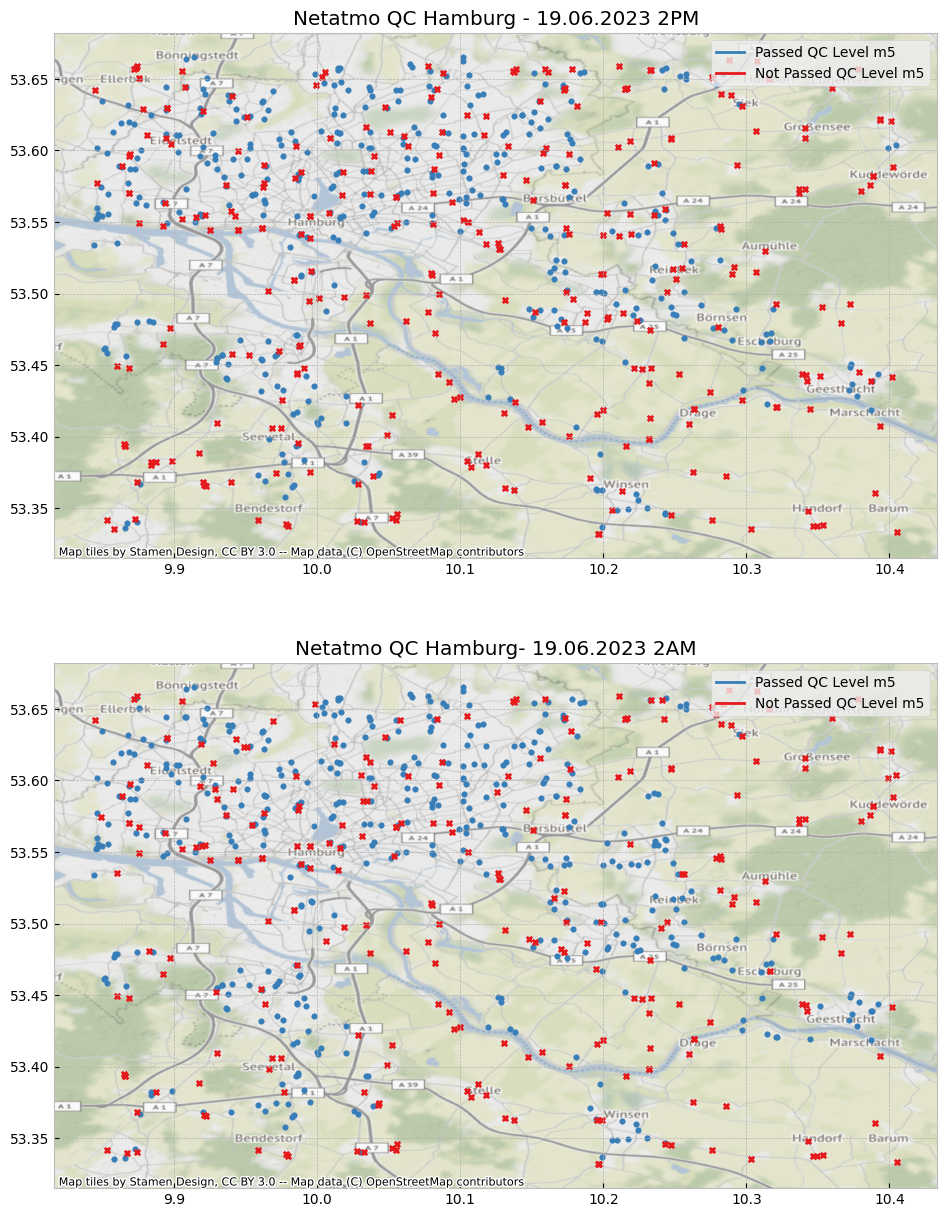

In [16]:
def plot_qc_locations(gdf1, gdf2, title, ax, crs):
    gdf1.plot(marker='o', ax=ax, markersize=15, color='#377eb8')
    gdf2.plot(marker='x', ax=ax, markersize=15, color='#e41a1c' )

    custom_lines = [Line2D([0], [0], color='#377eb8', lw=2),
                    Line2D([0], [0], color='#e41a1c', lw=2)]

    ax.legend(handles=custom_lines, labels=['Passed QC Level m5', 'Not Passed QC Level m5'], loc='upper right')

    # Set axis title and add basemap
    ax.set_title(title)
    ctx.add_basemap(
        ax,
        crs=crs,
        alpha=0.7,
        # source=ctx.providers.Stamen.TonerLite
    )

def plot_qc_locations_for_city(city, provider, crs, m5_gdf, rest_gdf):

    # Plot gdf
    fig, ax = plt.subplots(2, 1, figsize=(20,15))

    # Filter by time because first time everything is false
    m5_gdf_day = m5_gdf[m5_gdf['time'] == '2023-06-19 14:00:00']
    rest_gdf_day = rest_gdf[rest_gdf['time'] == '2023-06-19 14:00:00']

    plot_qc_locations(m5_gdf_day, rest_gdf_day, f'{provider} QC {city} - 19.06.2023 2PM', ax[0], crs)

    m5_gdf_night = m5_gdf[m5_gdf['time'] == '2023-06-19 02:00:00']
    rest_gdf_night = rest_gdf[rest_gdf['time'] == '2023-06-19 02:00:00']

    plot_qc_locations(m5_gdf_night, rest_gdf_night, f'{provider} QC {city}- 19.06.2023 2AM', ax[1], crs)

# plot_qc_locations_for_city('Stuttgart', 'Sensor.Community', crs_stuttgart)
plot_qc_locations_for_city('Hamburg', 'Netatmo', crs_stuttgart, hamburg_m5_gdf, hamburg_rest_gdf)

## Find Sensor Ids by Locations

### Sensor Locations Hamburg

In [3]:
# Approximatted locations based on QGIS exploration. Would be nice to have a map that shows the locations better.
Nienstedten = [53.552792,9.846225]
Stellingen = [53.593895,9.928416]
Fuhlsbüttel = [53.629954,10.012461]
Eimsbüttel = [53.569332,9.956562]
Eppendorf = [53.582269,9.986992]
Hafencity = [53.541312,9.988897]
Mümmelmansberg = [53.518018,10.165679]
WinsenLuhe = [53.348226,10.209836]
Emmelndorf = [53.393568,9.985493]
Harburg = [53.457814,9.971818]

names = ['Nienstedten', 'Stellingen', 'Fuhlsbüttel', 'Eimsbüttel', 'Eppendorf', 'Hafencity', 'Mümmelmansberg', 'WinsenLuhe', 'Emmelndorf', 'Harburg']
stations = pd.DataFrame([Nienstedten, Stellingen, Fuhlsbüttel, Eimsbüttel, Eppendorf, Hafencity, Mümmelmansberg, WinsenLuhe, Emmelndorf, Harburg])

p_ids_df = hamburg_m5_gdf.groupby('p_id').agg({'geometry': 'first'}).reset_index()
locations = list(p_ids_df['geometry'].apply(lambda x: (x.x, x.y)))

# More build time but better query time
tree = KDTree(locations, balanced_tree=True)

# Flatten list of x y coordinates
test_locations_gdf = gpd.GeoDataFrame(names, geometry=stations.iloc[:,:].apply(lambda row: Point(row[1], row[0]), axis=1), crs=crs)
ids = []
coordinates = []

for index, row in test_locations_gdf.iterrows():
    coords = row.geometry.coords
    test_location_df = create_neighbour_df(tree, coords, p_ids_df, hamburg_m5_gdf, None, 1, 0)
    ids.append(test_location_df.p_id.unique()[0])
    coordinates.append(test_location_df.geometry.unique()[0])

test_locations_gdf = pd.concat([test_locations_gdf, pd.DataFrame(ids), pd.DataFrame(coordinates)], axis=1, ignore_index=True)
test_locations_gdf.drop(1, axis=1, inplace=True)

test_locations_gdf.columns = ['location', 'p_id', 'geometry']
test_locations_gdf.set_geometry('geometry', inplace=True)

print(test_locations_gdf)

         location               p_id                   geometry
0     Nienstedten  70:ee:50:83:b1:e2   POINT (9.84540 53.55190)
1      Stellingen  70:ee:50:16:16:ce   POINT (9.92848 53.59705)
2     Fuhlsbüttel  70:ee:50:5e:d4:16  POINT (10.01145 53.62526)
3      Eimsbüttel  70:ee:50:00:d3:96   POINT (9.95431 53.56893)
4       Eppendorf  70:ee:50:6b:5f:50   POINT (9.98645 53.58332)
5       Hafencity  70:ee:50:00:d1:1c   POINT (9.98709 53.54097)
6  Mümmelmansberg  70:ee:50:5f:51:a0  POINT (10.16239 53.51496)
7      WinsenLuhe  70:ee:50:6b:97:86  POINT (10.20620 53.34835)
8      Emmelndorf  70:ee:50:28:f2:ca   POINT (9.98660 53.39425)
9         Harburg  70:ee:50:58:e8:70   POINT (9.97073 53.45599)


### Minimum Distance

In [75]:
neighbour_values = []
results = []

for index, row in test_locations_gdf.iterrows():
    coords = row.geometry.coords
    sensor_id = row.p_id

    print(f'Processing sensor {sensor_id}')

    for min_distance in [0, 0.5, 1, 2, 3, 5, 7, 10, 15]:
        n_df = create_neighbour_df(tree, coords, p_ids_df, hamburg_m5_gdf, sensor_id, 10, min_distance)
        # plot_neighbours_min_distance(crs, n_df, sensor_id)

        test_df = create_dataset_for_sensor_id(start, end, n_df, sensor_id, 30, 'netatmo', 10, 1, f'min_distance_{min_distance}', save=False)

        nr_columns = len(test_df.columns) - 1
        nr_neighbours = 10
        feature_count = 1
        provider = 'netatmo'

        y = test_df.iloc[:, 0].values
        features = test_df.iloc[:, nr_neighbours + 1:] # Select features from the end
        neighbour_values = test_df.iloc[:, 1:nr_neighbours + 1]

        X = pd.concat([neighbour_values, features], axis=1)

        # Evaluate model with RMSE and R2 with 5-fold cross-validation
        regr = HistGradientBoostingRegressor(max_iter=200, random_state=42)
        clf = make_pipeline(StandardScaler(), regr)
        rmse = make_scorer(mean_squared_error, greater_is_better=True, squared=False)

        scoring = {
            'rmse': rmse,
        }
    
        scores = cross_validate(clf, X, y, cv=5, scoring=scoring)

        for score in scores['test_rmse']:
            new = pd.DataFrame({
                "p_id": sensor_id,
                "n_neighbours": nr_neighbours,
                "n_features": feature_count,
                "RMSE": score,
                "provider": provider,
                "min_distance": min_distance,
                }, index=[0])

            results.append(new)


results_df = pd.concat(results)
display(results_df)

Processing sensor 70:ee:50:83:b1:e2
Processing sensor 70:ee:50:16:16:ce
Processing sensor 70:ee:50:5e:d4:16
Processing sensor 70:ee:50:00:d3:96
Processing sensor 70:ee:50:6b:5f:50
Processing sensor 70:ee:50:00:d1:1c
Processing sensor 70:ee:50:5f:51:a0
Processing sensor 70:ee:50:6b:97:86
Processing sensor 70:ee:50:28:f2:ca
Processing sensor 70:ee:50:58:e8:70


p_id  n_neighbours  n_features      RMSE provider  min_distance
0   70:ee:50:83:b1:e2            10           1  0.791467  netatmo           0.0
0   70:ee:50:83:b1:e2            10           1  0.422123  netatmo           0.0
0   70:ee:50:83:b1:e2            10           1  0.427020  netatmo           0.0
0   70:ee:50:83:b1:e2            10           1  0.501898  netatmo           0.0
0   70:ee:50:83:b1:e2            10           1  0.517419  netatmo           0.0
..                ...           ...         ...       ...      ...           ...
0   70:ee:50:58:e8:70            10           1  5.443290  netatmo          15.0
0   70:ee:50:58:e8:70            10           1  2.315779  netatmo          15.0
0   70:ee:50:58:e8:70            10           1  1.710646  netatmo          15.0
0   70:ee:50:58:e8:70            10           1  3.665577  netatmo          15.0
0   70:ee:50:58:e8:70            10           1  3.262459  netatmo          15.0

[450 rows x 6 columns]

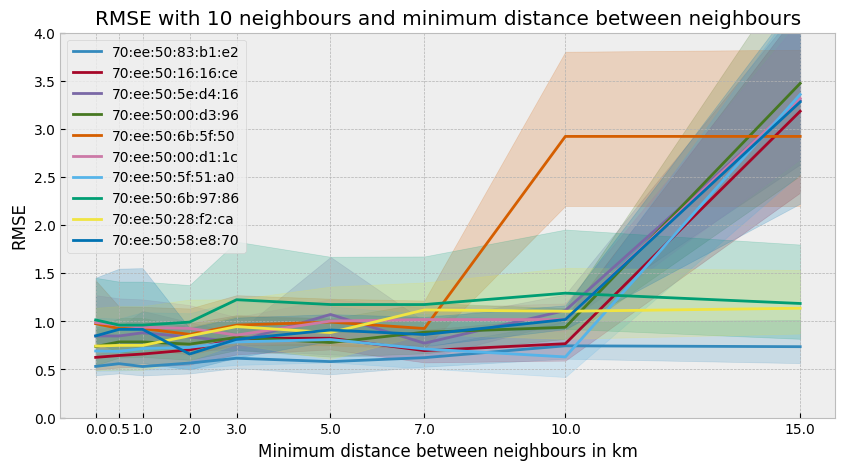

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the color palette for the lines
color_palette = sns.color_palette('tab10')  # You can choose other palettes or define custom colors

fig, ax = plt.subplots(figsize=(10, 5))

grouped_df = results_df

# Set the 'hue' parameter in each lineplot call to differentiate the lines based on the 'hue' value
sns.lineplot(data=grouped_df, x='min_distance', y='RMSE', ax=ax, hue="p_id", legend='auto', color=color_palette)
# sns.boxplot(data=grouped_df, x='min_distance', y='RMSE', ax=ax, hue="p_id")

ax.set_title('RMSE with 10 neighbours and minimum distance between neighbours')
ax.legend(loc='upper left')
custom_ticks = [0, 0.5, 1, 2, 3, 5, 7, 10, 15]
ax.set_xticks(custom_ticks)
# ax.get_xaxis().set_major_formatter(plt.ticklabel_format)
ax.set_xlabel('Minimum distance between neighbours in km')
ax.set_ylim(0, 4)
# adjust_box_widths(fig, 0.9)
plt.show()

In [32]:
comparison_df = results_df

print(comparison_df)

                 p_id  n_neighbours  n_features      RMSE        R2 provider  min_distance
0   70:ee:50:83:b1:e2            10           1  0.337090  0.992773  netatmo           0.0
0   70:ee:50:83:b1:e2            10           1  0.343057  0.992515  netatmo           0.5
0   70:ee:50:83:b1:e2            10           1  0.358138  0.991843  netatmo           1.0
0   70:ee:50:83:b1:e2            10           1  0.383109  0.990666  netatmo           2.0
0   70:ee:50:83:b1:e2            10           1  0.419452  0.988811  netatmo           3.0
..                ...           ...         ...       ...       ...      ...           ...
0   70:ee:50:58:e8:70            10           1  0.731571  0.975111  netatmo           6.0
0   70:ee:50:58:e8:70            10           1  0.539294  0.986475  netatmo           7.0
0   70:ee:50:58:e8:70            10           1  0.485103  0.989057  netatmo           8.0
0   70:ee:50:58:e8:70            10           1  0.495101  0.988601  netatmo           9.0

### Feature Importance
- Baseline: only temperature
- Time
- Humidity
- Pressure
- all 3

Testing with 30 neighbours, the 10 stations

Processing sensor 70:ee:50:83:b1:e2
Features sorted by their score for estimator 0:
Features sorted by their score for estimator 1:
Features sorted by their score for estimator 2:
Features sorted by their score for estimator 3:
Features sorted by their score for estimator 4:


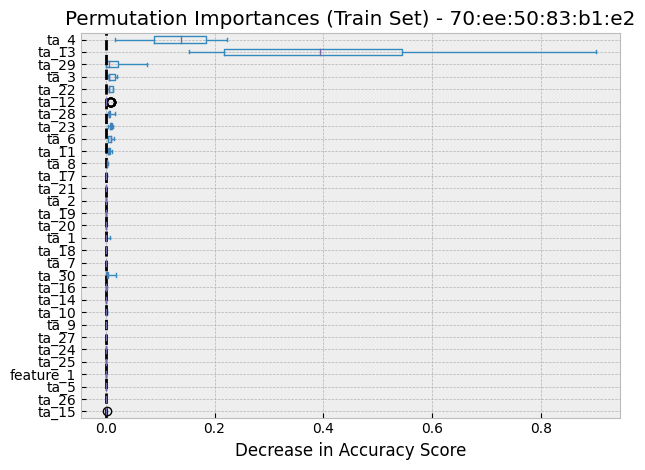

KeyboardInterrupt: 

In [164]:
from scipy.spatial import KDTree
from geopandas.tools import sjoin, sjoin_nearest
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer
from sklearn.inspection import permutation_importance

neighbour_values = []
results = []

nr_neighbours = 30

for index, row in test_locations_gdf.iterrows():
    coords = row.geometry.coords
    sensor_id = row.p_id

    print(f'Processing sensor {sensor_id}')

    for feature in [["time"], ["humidity"], ["pressure"], "all"]: # None,

        n_df = create_neighbour_df(tree, coords, p_ids_df, parent_gdf, sensor_id, nr_neighbours, min_distance=0)
        # plot_neighbours_min_distance(crs, n_df, sensor_id)

        test_df = create_dataset_for_sensor_id(start, end, n_df, sensor_id, 30, 'netatmo', nr_neighbours, f'min_distance_{min_distance}', save=False, features=feature)

        nr_columns = len(test_df.columns) - 1
        provider = 'netatmo'

        y = test_df.iloc[:, 0].values.tolist()
        neighbour_values = test_df.iloc[:, 1:nr_neighbours + 1]
        feature_values = test_df.iloc[:, nr_neighbours + 1:]

        X = pd.concat([neighbour_values, feature_values], axis=1)

        # Evaluate model with RMSE and R2 with 5-fold cross-validation
        regr = HistGradientBoostingRegressor(max_iter=200, random_state=42)
        # clf = make_pipeline(StandardScaler(), regr)
        rmse = make_scorer(mean_squared_error, greater_is_better=True, squared=False)

        scoring = {
            'rmse': rmse,
        }
    
        scores = cross_validate(regr, X, y, cv=5, scoring=scoring, return_estimator=True)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        importance_values = []

        # Calculate feature importance
        for idx,estimator in enumerate(scores['estimator']):
            print("Features sorted by their score for estimator {}:".format(idx))
            result = permutation_importance(
                estimator, X_test, y_test, n_repeats=10, random_state=42)
            sorted_importances_idx = result.importances_mean.argsort()
            importance = pd.DataFrame(
                result.importances[sorted_importances_idx].T,
                columns=X.columns[sorted_importances_idx],
            )
            importance['p_id'] = sensor_id
            importance_values.append(importance)


        importances = pd.concat(importance_values)

        ax = importances.plot.box(vert=False, whis=10)
        ax.set_title(f"Permutation Importances (Train Set) - {sensor_id}")
        ax.axvline(x=0, color="k", linestyle="--")
        ax.set_xlabel("Decrease in Accuracy Score")
        ax.figure.tight_layout()
        plt.show()
        

        for score in scores['test_rmse']:
            new = pd.DataFrame({
                "p_id": sensor_id,
                "n_neighbours": nr_neighbours,
                "feature": feature,
                "RMSE": score,
                "provider": provider
                }, index=[0])

            results.append(new)


feature_selection_df = pd.concat(results)

# Replace None in feature column with 'None' string
feature_selection_df['feature'] = feature_selection_df['feature'].fillna('None')

display(feature_selection_df)

/var/folders/z3/h6bhdk4x1r5_qqbdjrvk0b5m0000gn/T/ipykernel_13129/3608204396.py:274: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if np.all(l.get_xdata() == [xmin, xmax]):


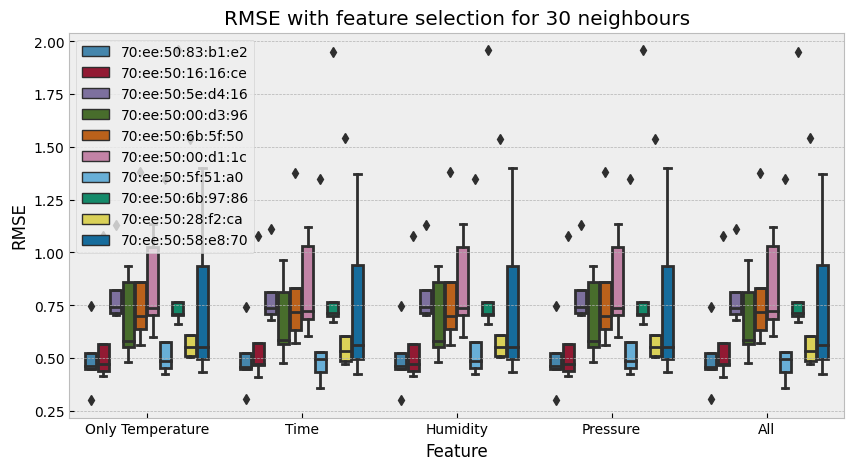

In [157]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the color palette for the lines
color_palette = sns.color_palette('tab10')  # You can choose other palettes or define custom colors

fig, ax = plt.subplots(figsize=(10, 5))

# Set the 'hue' parameter in each lineplot call to differentiate the lines based on the 'hue' value
# sns.lineplot(data=feature_importance_df, x='feature', y='RMSE', ax=ax, hue="p_id", legend='auto', color=color_palette)
sns.boxplot(data=feature_selection_df, x='feature', y='RMSE', ax=ax, hue="p_id")

ax.set_title('RMSE with feature selection for 30 neighbours')
ax.legend(loc='upper left')
custom_labels = ["Only Temperature", "Time", "Humidity", "Pressure", "All"]

# Set the location of the xticks
ax.set_xticklabels(custom_labels)

# ax.get_xaxis().set_major_formatter(plt.ticklabel_format)
ax.set_xlabel('Feature')
# ax.set_ylim(0.4, 0.6)
adjust_box_widths(fig, 0.9)
plt.show()

### QC Level Comparison m4 vs m5

In [21]:
from scipy.spatial import KDTree
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.inspection import permutation_importance

results = []

nr_neighbours = 30

m5_gdf = hamburg_m5_gdf
m4_gdf = hamburg_gdf[hamburg_gdf['m4'] == True]
m3_gdf = hamburg_gdf[hamburg_gdf['m3'] == True]

for index, row in test_locations_gdf.iterrows():
    coords = row.geometry.coords
    sensor_id = row.p_id

    print(f'Processing sensor {sensor_id}')

    for target_tuple in [(m5_gdf, "m5"), (m4_gdf, "m4"), (m3_gdf, "m3")]:
        target_gdf = target_tuple[0]
        target_qc_level = target_tuple[1]

        print(f'Processing target QC level {target_qc_level}')

        n_df = create_neighbour_df(tree, coords, p_ids_df, target_gdf, sensor_id, nr_neighbours, min_distance=0)
        # plot_neighbours_min_distance(crs, n_df, sensor_id)

        test_df = create_dataset_for_sensor_id(start, end, n_df, sensor_id, 30, 'netatmo', nr_neighbours, None, save=False)

        nr_columns = len(test_df.columns) - 1
        provider = 'netatmo'

        y = test_df.iloc[:, 0].values.tolist()
        X = test_df.iloc[:, 1:nr_neighbours + 1]

        # Evaluate model with RMSE and R2 with 5-fold cross-validation
        regr = HistGradientBoostingRegressor(max_iter=200, random_state=42)
        # clf = make_pipeline(StandardScaler(), regr)
        rmse = make_scorer(mean_squared_error, greater_is_better=True, squared=False)

        scoring = {
            'rmse': rmse,
        }
    
        scores = cross_validate(regr, X, y, cv=5, scoring=scoring)      

        for score in scores['test_rmse']:
            new = pd.DataFrame({
                "p_id": sensor_id,
                "n_neighbours": nr_neighbours,
                "qc_level": target_qc_level,
                "RMSE": score,
                "provider": provider
                }, index=[0])

            results.append(new)


qc_compare_df = pd.concat(results)

display(qc_compare_df)

Processing sensor 70:ee:50:83:b1:e2
Processing target QC level m5
Processing target QC level m4
Processing target QC level m3
Processing sensor 70:ee:50:16:16:ce
Processing target QC level m5
Processing target QC level m4
Processing target QC level m3
Processing sensor 70:ee:50:5e:d4:16
Processing target QC level m5
Processing target QC level m4
Processing target QC level m3
Processing sensor 70:ee:50:00:d3:96
Processing target QC level m5
Processing target QC level m4
Processing target QC level m3
Processing sensor 70:ee:50:6b:5f:50
Processing target QC level m5
Processing target QC level m4
Processing target QC level m3
Processing sensor 70:ee:50:00:d1:1c
Processing target QC level m5
Processing target QC level m4
Processing target QC level m3
Processing sensor 70:ee:50:5f:51:a0
Processing target QC level m5
Processing target QC level m4
Processing target QC level m3
Processing sensor 70:ee:50:6b:97:86
Processing target QC level m5
Processing target QC level m4
Processing target QC l

p_id  n_neighbours qc_level      RMSE provider
0   70:ee:50:83:b1:e2            30       m5  0.745372  netatmo
0   70:ee:50:83:b1:e2            30       m5  0.300999  netatmo
0   70:ee:50:83:b1:e2            30       m5  0.524311  netatmo
0   70:ee:50:83:b1:e2            30       m5  0.462592  netatmo
0   70:ee:50:83:b1:e2            30       m5  0.450292  netatmo
..                ...           ...      ...       ...      ...
0   70:ee:50:58:e8:70            30       m3  0.921455  netatmo
0   70:ee:50:58:e8:70            30       m3  0.386217  netatmo
0   70:ee:50:58:e8:70            30       m3  0.513584  netatmo
0   70:ee:50:58:e8:70            30       m3  0.376225  netatmo
0   70:ee:50:58:e8:70            30       m3  0.471299  netatmo

[150 rows x 5 columns]

/var/folders/z3/h6bhdk4x1r5_qqbdjrvk0b5m0000gn/T/ipykernel_9277/559436632.py:332: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if np.all(l.get_xdata() == [xmin, xmax]):


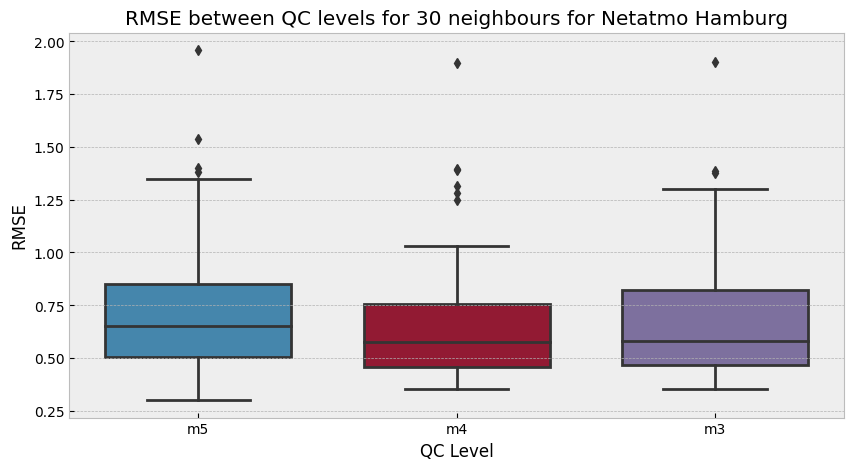

In [22]:
# Define the color palette for the lines
color_palette = sns.color_palette('tab10')  # You can choose other palettes or define custom colors

fig, ax = plt.subplots(figsize=(10, 5))

# Set the 'hue' parameter in each lineplot call to differentiate the lines based on the 'hue' value
# sns.lineplot(data=simulated_results_df, x='interval', y='RMSE', ax=ax, hue="nr_moving_sensors", legend='auto', color=color_palette)
sns.boxplot(data=qc_compare_df, x='qc_level', y='RMSE', ax=ax)

ax.set_title('RMSE between QC levels for 30 neighbours for Netatmo Hamburg')
# ax.legend(loc='upper left')
# custom_labels = ["Original", "Simulated"]

# # Set the location of the xticks
# ax.set_xticklabels(custom_labels)

ax.set_xlabel('QC Level')
# ax.set_ylim(0.4, 0.6)
adjust_box_widths(fig, 0.9)

plt.show()

### Moving Stations Exploration

- test m4 vs m5 qc data for reference
- simluate moving sensor with m4 data because less missing values? (else we could also only select stations with not many missing values)

- test time intervals for 70:ee:50:83:b1:e2 with neighbour 4 (and maybe check permutation importances to verify that the importance of the moving sensor has lessend?)
- have more neighbours as simulated moving sensors with different time intevals
...

In [64]:
sensor_id = "70:ee:50:83:b1:e2"
interval_sensor = test_locations_gdf[test_locations_gdf["p_id"] == sensor_id].iloc[0]
nr_neighbours = 30
min_distance = 0

# m4_gdf = hamburg_gdf[hamburg_gdf['m4'] == True]

coords = interval_sensor.geometry.coords

n_df = create_neighbour_df(tree, coords, p_ids_df, hamburg_m5_gdf, sensor_id, nr_neighbours, min_distance=0)
n_df = n_df.sort_values(by=['distance'])
neighbour_ids = pd.Series(n_df['p_id'].unique()[0:nr_neighbours + 1])

# Define time intervals for specific sensors
simulated_moving_sensors = ["70:ee:50:3f:1f:1c", "70:ee:50:96:d9:70"]
p_id_remaining = neighbour_ids[~neighbour_ids.isin(simulated_moving_sensors) & ~neighbour_ids.isin([sensor_id])]
p_id_remaining = p_id_remaining.sample(frac=1, random_state=42)

importance_values = []
results = []

for size_to_increase in [0, 3, 8, 13, 18, 28]:

    moving_sensor_ids = p_id_remaining[0:size_to_increase].append(pd.Series(simulated_moving_sensors))
    nr_moving_sensors = len(moving_sensor_ids)

    for sample_size in [None, 10, 50, 100, 200, 500, 1000, "all"]:
        print(f"Sample size: {sample_size} - Moving sensors: {nr_moving_sensors}")

        # Decide on resampled sensors by id (f.e. by permutation importance)
        # Turn moving_sensor_ids into dict with id : sample_size
        resampled_sensors = { sensor_id: sample_size for sensor_id in moving_sensor_ids }

        n_simulated_df = create_neighbour_df(tree, coords, p_ids_df, hamburg_m5_gdf, sensor_id, nr_neighbours, min_distance=0, simulated_sensors=resampled_sensors, neighbour_ids=neighbour_ids)
        n_simulated_df = n_simulated_df.sort_values(by=['distance'])

        test_simulated_df = create_dataset_for_sensor_id(start, end, n_simulated_df, sensor_id, 30, 'netatmo', nr_neighbours, f'min_distance_{min_distance}', save=False, features=None, neighbour_ids=neighbour_ids, use_p_id_labels=True)

        if test_simulated_df is None:
            print(f"Sensor {sensor_id} has no data for sample_size {sample_size} with moving sensors {nr_moving_sensors}")
            continue

        provider = 'netatmo'

        y = test_simulated_df.iloc[:, 0].values.tolist()
        X = test_simulated_df.iloc[:, 1:nr_neighbours + 1]

        # Evaluate model with RMSE and R2 with 5-fold cross-validation
        regr = HistGradientBoostingRegressor(max_iter=200, random_state=42)
        # clf = make_pipeline(StandardScaler(), regr)
        rmse = make_scorer(mean_squared_error, greater_is_better=True, squared=False)

        scoring = {
            'rmse': rmse,
        }

        scores = cross_validate(regr, X, y, cv=5, scoring=scoring)

        for score in scores['test_rmse']:
            new = pd.DataFrame({
                "p_id": sensor_id,
                "n_neighbours": nr_neighbours,
                "RMSE": score,
                "sample_size": sample_size,
                "nr_moving_sensors": nr_moving_sensors
                }, index=[0])

            results.append(new)

simulated_results_df = pd.concat(results)

simulated_results_df['sample_size'] = simulated_results_df['sample_size'].fillna('Removed')
simulated_results_df['sample_size'] = simulated_results_df['sample_size'].astype(str)

/var/folders/z3/h6bhdk4x1r5_qqbdjrvk0b5m0000gn/T/ipykernel_4110/1527272210.py:24: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  moving_sensor_ids = p_id_remaining[0:size_to_increase].append(pd.Series(simulated_moving_sensors))


Sample size: None - Moving sensors: 2
Sample size: 10 - Moving sensors: 2
Sample size: 50 - Moving sensors: 2
Sample size: 100 - Moving sensors: 2
Sample size: 200 - Moving sensors: 2
Sample size: 500 - Moving sensors: 2
Sample size: 1000 - Moving sensors: 2
Sample size: all - Moving sensors: 2


/var/folders/z3/h6bhdk4x1r5_qqbdjrvk0b5m0000gn/T/ipykernel_4110/1527272210.py:24: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  moving_sensor_ids = p_id_remaining[0:size_to_increase].append(pd.Series(simulated_moving_sensors))


Sample size: None - Moving sensors: 5
Sample size: 10 - Moving sensors: 5
Sample size: 50 - Moving sensors: 5
Sample size: 100 - Moving sensors: 5
Sample size: 200 - Moving sensors: 5
Sample size: 500 - Moving sensors: 5
Sample size: 1000 - Moving sensors: 5
Sample size: all - Moving sensors: 5


/var/folders/z3/h6bhdk4x1r5_qqbdjrvk0b5m0000gn/T/ipykernel_4110/1527272210.py:24: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  moving_sensor_ids = p_id_remaining[0:size_to_increase].append(pd.Series(simulated_moving_sensors))


Sample size: None - Moving sensors: 10
Sample size: 10 - Moving sensors: 10
Sample size: 50 - Moving sensors: 10
Sample size: 100 - Moving sensors: 10
Sample size: 200 - Moving sensors: 10
Sample size: 500 - Moving sensors: 10
Sample size: 1000 - Moving sensors: 10
Sample size: all - Moving sensors: 10


/var/folders/z3/h6bhdk4x1r5_qqbdjrvk0b5m0000gn/T/ipykernel_4110/1527272210.py:24: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  moving_sensor_ids = p_id_remaining[0:size_to_increase].append(pd.Series(simulated_moving_sensors))


Sample size: None - Moving sensors: 15
Sample size: 10 - Moving sensors: 15
Sample size: 50 - Moving sensors: 15
Sample size: 100 - Moving sensors: 15
Sample size: 200 - Moving sensors: 15
Sample size: 500 - Moving sensors: 15
Sample size: 1000 - Moving sensors: 15
Sample size: all - Moving sensors: 15


/var/folders/z3/h6bhdk4x1r5_qqbdjrvk0b5m0000gn/T/ipykernel_4110/1527272210.py:24: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  moving_sensor_ids = p_id_remaining[0:size_to_increase].append(pd.Series(simulated_moving_sensors))


Sample size: None - Moving sensors: 20
Sample size: 10 - Moving sensors: 20
Sample size: 50 - Moving sensors: 20
Sample size: 100 - Moving sensors: 20
Sample size: 200 - Moving sensors: 20
Sample size: 500 - Moving sensors: 20
Sample size: 1000 - Moving sensors: 20
Sample size: all - Moving sensors: 20


/var/folders/z3/h6bhdk4x1r5_qqbdjrvk0b5m0000gn/T/ipykernel_4110/1527272210.py:24: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  moving_sensor_ids = p_id_remaining[0:size_to_increase].append(pd.Series(simulated_moving_sensors))


Sample size: None - Moving sensors: 30
Sample size: 10 - Moving sensors: 30
Sample size: 50 - Moving sensors: 30
Sample size: 100 - Moving sensors: 30
Sample size: 200 - Moving sensors: 30
Sample size: 500 - Moving sensors: 30
Sample size: 1000 - Moving sensors: 30
Sample size: all - Moving sensors: 30


In [37]:
test_df = simulated_results_df.groupby(['nr_moving_sensors', 'sample_size']).agg({'RMSE': 'mean'})
display(test_df)

RMSE
nr_moving_sensors sample_size          
2                 10           1.632363
                  100          1.622874
                  1000         1.576791
                  200          1.618001
                  50           1.632363
                  500          1.630417
                  All          1.576791
                  Removed      1.632363
5                 10           1.650199
                  100          1.648259
                  1000         1.638636
                  200          1.656489
                  50           1.648570
                  500          1.633334
                  All          1.576791
                  Removed      1.650199

/var/folders/z3/h6bhdk4x1r5_qqbdjrvk0b5m0000gn/T/ipykernel_4110/3416576522.py:342: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if np.all(l.get_xdata() == [xmin, xmax]):
/var/folders/z3/h6bhdk4x1r5_qqbdjrvk0b5m0000gn/T/ipykernel_4110/3416576522.py:342: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if np.all(l.get_xdata() == [xmin, xmax]):


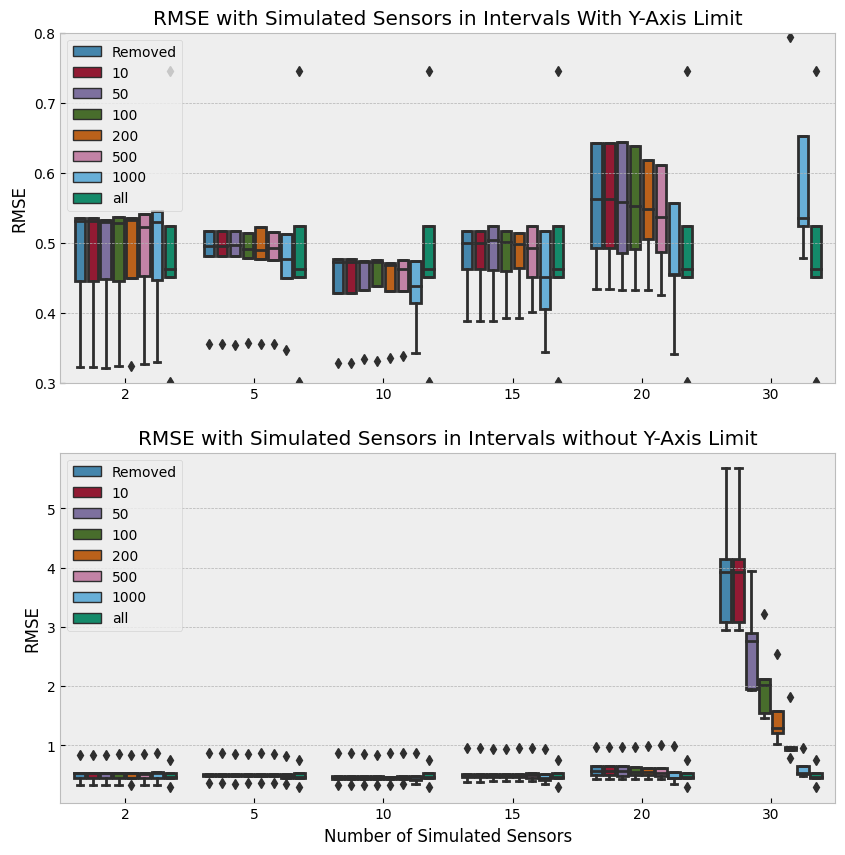

In [72]:
# Define the color palette for the lines
color_palette = sns.color_palette('tab10')  # You can choose other palettes or define custom colors

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

ax = axs[0]

sns.boxplot(data=simulated_results_df, x='nr_moving_sensors', y='RMSE', hue="sample_size", ax=ax)

ax.set_title('RMSE with Simulated Sensors in Intervals With Y-Axis Limit')
ax.legend(loc='upper left')

ax.set_xlabel(None)
ax.set_ylim(0.3, 0.8)
adjust_box_widths(fig, 0.9)

ax = axs[1]

sns.boxplot(data=simulated_results_df, x='nr_moving_sensors', y='RMSE', hue="sample_size", ax=ax)

ax.set_title('RMSE with Simulated Sensors in Intervals without Y-Axis Limit')
ax.legend(loc='upper left')

ax.set_xlabel('Number of Simulated Sensors')
adjust_box_widths(fig, 0.9)

plt.show()

In [184]:
print(neighbour_ids[0])
grouped_importance = importances.groupby('p_id').agg({'ta_4': 'mean', 'ta_13': 'mean'})
print(grouped_importance)
#print(importances.columns)
print(neighbour_ids[4])
print(neighbour_ids[13])

70:ee:50:83:b1:e2
                      ta_4     ta_13
p_id                                
70:ee:50:83:b1:e2  0.12803  0.440061
70:ee:50:96:d9:70
70:ee:50:3f:1f:1c


In [ ]:
interval_sensor_id = "70:ee:50:83:b1:e2"
eval_permutation_importance = False

print(f'Processing sensor {sensor_id} for moving sensor simulation')

# Define time intervals for specific sensors
simulated_moving_sensors = ["70:ee:50:3f:1f:1c", "70:ee:50:96:d9:70"]

for simulated_moving_sensor in simulated_moving_sensors:

    for interval in [None, '1H', '2H', '4H', '6H', '8H', '10H', '12H', '24H']:

    n_df = create_neighbour_df(tree, coords, p_ids_df, parent_gdf, sensor_id, nr_neighbours, min_distance=0)
    # plot_neighbours_min_distance(crs, n_df, sensor_id)

    test_df = create_dataset_for_sensor_id(start, end, n_df, sensor_id, 30, 'netatmo', nr_neighbours, f'min_distance_{min_distance}', save=False, features=feature)

    nr_columns = len(test_df.columns) - 1
    provider = 'netatmo'

    y = test_df.iloc[:, 0].values.tolist()
    neighbour_values = test_df.iloc[:, 1:nr_neighbours + 1]
    feature_values = test_df.iloc[:, nr_neighbours + 1:]

    X = pd.concat([neighbour_values, feature_values], axis=1)

    # Evaluate model with RMSE and R2 with 5-fold cross-validation
    regr = HistGradientBoostingRegressor(max_iter=200, random_state=42)
    # clf = make_pipeline(StandardScaler(), regr)
    rmse = make_scorer(mean_squared_error, greater_is_better=True, squared=False)

    scoring = {
        'rmse': rmse,
    }

    scores = cross_validate(regr, X, y, cv=5, scoring=scoring, return_estimator=True)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    importance_values = []

    if eval_permutation_importance:
        # Calculate feature importance
        for idx,estimator in enumerate(scores['estimator']):
            print("Features sorted by their score for estimator {}:".format(idx))
            result = permutation_importance(
                estimator, X_test, y_test, n_repeats=10, random_state=42)
            sorted_importances_idx = result.importances_mean.argsort()
            importance = pd.DataFrame(
                result.importances[sorted_importances_idx].T,
                columns=X.columns[sorted_importances_idx],
            )
            importance['p_id'] = sensor_id
            importance_values.append(importance)

    if eval_permutation_importance:
        importances = pd.concat(importance_values)

        ax = importances.plot.box(vert=False, whis=10)
        ax.set_title(f"Permutation Importances (Train Set) - {sensor_id}")
        ax.axvline(x=0, color="k", linestyle="--")
        ax.set_xlabel("Decrease in Accuracy Score")
        ax.figure.tight_layout()
        plt.show()

    for score in scores['test_rmse']:
        new = pd.DataFrame({
            "p_id": sensor_id,
            "n_neighbours": nr_neighbours,
            "feature": feature,
            "RMSE": score,
            "provider": provider
            }, index=[0])

        results.append(new)


moving_sensors_df = pd.concat(results)

display(moving_sensors_df)

### Other stuff dataset related

Text(0.5, 0, 'Date')

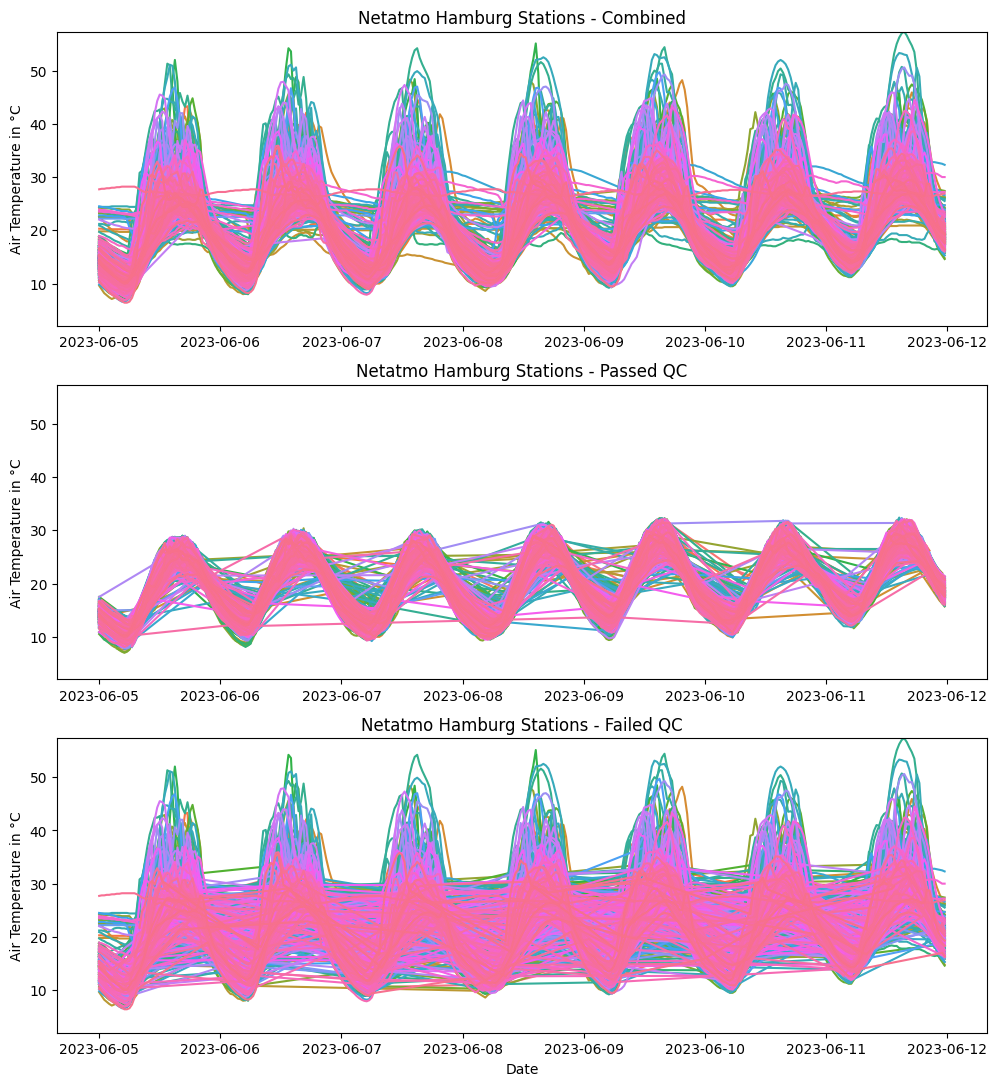

In [98]:
import seaborn as sns
import matplotlib.dates as md

# Plot lines of temperature of stations

# Plot daily_mean_temp_2m as line plot
fig, ax = plt.subplots(3, 1, figsize=(12, 13))
ymin, ymax = qc_gdf.ta.min(), qc_gdf.ta.max()

def plot_stations_ta(gdf, ax, title):
    grouped_df = gdf.groupby([pd.Grouper(key='p_id'), pd.Grouper(key="time", freq="10T")]).agg({'ta': 'first'})

    sns.lineplot(x='time', 
             y='ta',
             hue='p_id', 
             data=grouped_df,
             ax=ax,
             legend=False)
    ax.set_ylabel('Air Temperature in °C')
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel(None)
    ax.set_title(title)

plot_stations_ta(qc_gdf[(qc_gdf['time'] >= '2023-06-05') & (qc_gdf['time'] < '2023-06-12')], ax[0], 'Netatmo Hamburg Stations - Combined')
plot_stations_ta(parent_gdf[(parent_gdf['time'] >= '2023-06-05') & (parent_gdf['time'] < '2023-06-12')], ax[1], 'Netatmo Hamburg Stations - Passed QC')
plot_stations_ta(rest_gdf[(rest_gdf['time'] >= '2023-06-05') & (rest_gdf['time'] < '2023-06-12')], ax[2], 'Netatmo Hamburg Stations - Failed QC')

ax[2].set_xlabel('Date')

## Dataset Creation For ML

### Script

In [138]:
nn_count = 50
feature_count = 1
stuttgart_interval = 10
netatmo_interval = 30

p_ids_df = qc_gdf.groupby('p_id').agg({'geometry': 'first'}).reset_index()
locations = list(p_ids_df['geometry'].apply(lambda x: (x.x, x.y)))

print('Building tree...')
# More build time but better query time
tree = KDTree(locations, balanced_tree=True)
p_ids_df.reset_index(drop=True, inplace=True)

for index, row in p_ids_df.iterrows():
    print(index)
    coords = row.geometry.coords
    neighbours_gdf, neighbour_ids = create_neighbour_df(coords)

    create_dataset_for_sensor_id(start, end, columns, neighbours_gdf, neighbour_ids, row.p_id, stuttgart_interval, 'sensor.community')


Building tree...
0
No data for sensor 108 with 0 entries
1
2
3
4
5
No data for sensor 212 with 0 entries
6
7
No data for sensor 254 with 0 entries
8
9
10
11
12
No data for sensor 364 with 0 entries
13
No data for sensor 418 with 0 entries
14
15
16
No data for sensor 431 with 0 entries
17
No data for sensor 435 with 0 entries
18
19
No data for sensor 480 with 0 entries
20
No data for sensor 498 with 0 entries
21
22
23
No data for sensor 530 with 0 entries
24
No data for sensor 550 with 0 entries
25
26
27
28
29
30
No data for sensor 674 with 0 entries
31
32
33
34
35
36
No data for sensor 736 with 0 entries
37
No data for sensor 752 with 0 entries
38
No data for sensor 758 with 0 entries
39
No data for sensor 770 with 0 entries
40
41
42
No data for sensor 796 with 0 entries
43
44
45
46
No data for sensor 843 with 0 entries
47
48
49
50
No data for sensor 1205 with 0 entries
51
52
No data for sensor 1329 with 0 entries
53
54
No data for sensor 1347 with 0 entries
55
No data for sensor 1367 

# ML Model Eval

In [39]:
# Create test dataset
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
import os

# Ignore divide by NaN warnings for normalisation
np.seterr(divide='ignore', invalid='ignore')

provider = 'netatmo'
feature_count = 1
results = []

# Test for different number of nearest neighbours
def evaluate_regressor(sensor_id, nr_neighbours, y_test, y_pred, regressor_type, is_imputed):
    return pd.DataFrame({
            "p_id": sensor_id,
            "n_neighbours": nr_neighbours,
            "n_features": feature_count,
            "regressor_type": regressor_type,
            "MAE": mean_absolute_error(y_test, y_pred),
            "MSE": mean_squared_error(y_test, y_pred),
            "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
            "R2": r2_score(y_test, y_pred),
            "is_imputed": is_imputed,
            "provider": provider
            }, index=[0])

for index, row in p_ids_df.iterrows():
    sensor_id = row.p_id

    print(f'Processing {sensor_id}')

    file_path = f'./data/testsets/{provider}/{sensor_id}_dataset.csv'
    if not os.path.isfile(file_path):
        print(f'File {file_path} does not exist')
        continue

    parent_df = pd.read_csv(file_path)
    parent_df.dropna(subset=['y'], inplace=True)

    parent_df_imput = parent_df.copy()

    for index, row in parent_df_imput.iterrows():
        if row.isnull().values.all():
            row.drop(inplace=True)
        row.fillna(row.mean(), inplace=True)

    nr_columns = len(parent_df.columns) - 1 # remove index column

    for nr_neighbours in range(2, 33, 5):
        y = parent_df.iloc[:, 0].values
        features = parent_df.iloc[:, nr_columns:nr_columns-feature_count:-1] # Select features from the end
        neighbour_values = parent_df.iloc[:, 1:nr_neighbours + 1]

        y_imput = parent_df_imput.iloc[:, 0].values
        features_imput = parent_df_imput.iloc[:, nr_columns:nr_columns-feature_count:-1] # Select features from the end
        neighbours_imput = parent_df_imput.iloc[:, 1:nr_neighbours + 1]

        # Select number of neighbours
        X = pd.concat([neighbour_values, features], axis=1)
        X_imput = pd.concat([neighbours_imput, features_imput], axis=1)

        if X.empty or X_imput.empty:
            print(f'Empty dataset for {sensor_id} and neighbour count {nr_neighbours}')
            continue

        if len(X.values) < 5 or len(X_imput.values) < 5:
            print(f'Not enough data for {sensor_id} and neighbour count {nr_neighbours} with {len(X.values)} rows')
            continue

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=1, shuffle=True)

        X_train_imput, X_test_imput, y_train_imput, y_test_imput = train_test_split(
            X_imput, y_imput, test_size=0.3, random_state=1, shuffle=True)
        
        scaler_X = StandardScaler().fit(X_train)
        X_train_norm = scaler_X.transform(X_train)
        X_test_norm = scaler_X.transform(X_test)

        scaler_X_imput = StandardScaler().fit(X_train_imput)
        X_train_imput_norm = scaler_X_imput.transform(X_train_imput)
        X_test_imput_norm = scaler_X_imput.transform(X_test_imput)

        # Run regression for imputed df
        for regr in [("LinearRegressor", LinearRegression()), ("KNN", KNeighborsRegressor(n_neighbors=5, weights='distance')), ("RandomForest", RandomForestRegressor(n_estimators=200, random_state=42)), ("SVMRegressor", SVR(kernel='rbf', gamma='auto')), ("HistGradientBoostingRegressor", HistGradientBoostingRegressor(max_iter=200, random_state=42))]:
            regr_name = regr[0]
            regr = regr[1]

            print(f'Running {regr_name} for {sensor_id} and neighbour count {nr_neighbours}')

            y_pred = None

            regr.fit(X_train_imput_norm, y_train)
            y_pred = regr.predict(X_test_imput_norm)

            results.append(evaluate_regressor(sensor_id, nr_neighbours, y_test, y_pred, regr_name, True))
        
        # Run regression without imputed df
        for regr in [("HistGradientBoostingRegressor", HistGradientBoostingRegressor(max_iter=200, random_state=42))]:
            regr_name = regr[0]
            regr = regr[1]

            y_pred = None

            regr.fit(X_train_norm, y_train)
            y_pred = regr.predict(X_test_norm)

            results.append(evaluate_regressor(sensor_id, nr_neighbours, y_test, y_pred, regr_name, False))

eval_df = pd.concat(results).reset_index(drop=True)
print(eval_df)

Processing 70:ee:50:00:1c:3a
File ./data/testsets/netatmo/70:ee:50:00:1c:3a_dataset.csv does not exist
Processing 70:ee:50:00:1e:4c
Running LinearRegressor for 70:ee:50:00:1e:4c and neighbour count 2
Running KNN for 70:ee:50:00:1e:4c and neighbour count 2
Running RandomForest for 70:ee:50:00:1e:4c and neighbour count 2
Running SVMRegressor for 70:ee:50:00:1e:4c and neighbour count 2
Running HistGradientBoostingRegressor for 70:ee:50:00:1e:4c and neighbour count 2
Running LinearRegressor for 70:ee:50:00:1e:4c and neighbour count 7
Running KNN for 70:ee:50:00:1e:4c and neighbour count 7
Running RandomForest for 70:ee:50:00:1e:4c and neighbour count 7
Running SVMRegressor for 70:ee:50:00:1e:4c and neighbour count 7
Running HistGradientBoostingRegressor for 70:ee:50:00:1e:4c and neighbour count 7
Running LinearRegressor for 70:ee:50:00:1e:4c and neighbour count 12
Running KNN for 70:ee:50:00:1e:4c and neighbour count 12
Running RandomForest for 70:ee:50:00:1e:4c and neighbour count 12
Runn

In [15]:
# Print whole df to check data
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(eval_df)

    p_id n_neighbours n_features                 regressor_type       MAE  \
0    113            1          1                LinearRegressor  0.441602   
1    113            1          1                            KNN  0.408394   
2    113            1          1                   RandomForest  0.394834   
3    113            1          1                   SVMRegressor  0.391134   
4    113            1          1  HistGradientBoostingRegressor  0.378565   
5    113            1          1  HistGradientBoostingRegressor  2.264957   
6    113            6          1                LinearRegressor  0.436437   
7    113            6          1                            KNN  0.294864   
8    113            6          1                   RandomForest  0.310908   
9    113            6          1                   SVMRegressor  0.378238   
10   113            6          1  HistGradientBoostingRegressor  0.322654   
11   113            6          1  HistGradientBoostingRegressor  0.323498   

In [41]:
# Care to not override existing eval files
# eval_df.to_csv('data/evaluation/eval_df_all_hamburg.csv', index=False)
# eval_df.to_csv('data/evaluation/eval_df_all_stuttgart.csv', index=False)

In [2]:
import pandas as pd

# Load statistics
eval_df_hamburg = pd.read_csv('data/evaluation/eval_df_all_hamburg.csv')
eval_df_hamburg["provider"] = "Netatmo"
eval_df_stuttgart = pd.read_csv('data/evaluation/eval_df_all_stuttgart.csv')
eval_df_stuttgart["provider"] = "Sensor.Community"

eval_df = pd.concat([eval_df_hamburg, eval_df_stuttgart])

print(eval_df)

                   p_id  n_neighbours  n_features  \
0     70:ee:50:00:1e:4c             2           1   
1     70:ee:50:00:1e:4c             2           1   
2     70:ee:50:00:1e:4c             2           1   
3     70:ee:50:00:1e:4c             2           1   
4     70:ee:50:00:1e:4c             2           1   
...                 ...           ...         ...   
9193              80405            32           1   
9194              80405            32           1   
9195              80405            32           1   
9196              80405            32           1   
9197              80405            32           1   

                     regressor_type       MAE       MSE      RMSE        R2  \
0                   LinearRegressor  0.580101  0.591265  0.768937  0.977373   
1                               KNN  0.496249  0.512830  0.716122  0.980374   
2                      RandomForest  0.530299  0.557294  0.746521  0.978673   
3                      SVMRegressor  0.532549  

In [48]:
# Print statistics for eval_df based on regressor_type and is_imputed
# Input: eval_df
# Output: None

def print_stats(eval_df):
    grouped_eval = eval_df.groupby(['provider','regressor_type', 'is_imputed', 'p_id']).agg({'MAE': ['min', 'max']})
    grouped_eval.columns = ['MAE_min', 'MAE_max']
    print(grouped_eval)

print_stats(eval_df)

                                                                              MAE_min  \
provider         regressor_type                is_imputed p_id                          
Netatmo          HistGradientBoostingRegressor False      70:ee:50:00:1e:4c  0.256148   
                                                          70:ee:50:00:37:4e  0.332158   
                                                          70:ee:50:00:47:44  0.476771   
                                                          70:ee:50:00:70:4e  0.354989   
                                                          70:ee:50:00:79:de  0.224502   
...                                                                               ...   
Sensor.Community SVMRegressor                  True       77865              0.410329   
                                                          78741              0.576871   
                                                          79242              0.411524   
                     

In [50]:
# Helpers

from matplotlib.patches import PathPatch

def adjust_box_widths(g, fac):
    """
    Adjust the withs of a seaborn-generated boxplot.
    """

    # iterating through Axes instances
    for ax in g.axes:

        # iterating through axes artists:
        for c in ax.get_children():

            # searching for PathPatches
            if isinstance(c, PathPatch):
                # getting current width of box:
                p = c.get_path()
                verts = p.vertices
                verts_sub = verts[:-1]
                xmin = np.min(verts_sub[:, 0])
                xmax = np.max(verts_sub[:, 0])
                xmid = 0.5*(xmin+xmax)
                xhalf = 0.5*(xmax - xmin)

                # setting new width of box
                xmin_new = xmid-fac*xhalf
                xmax_new = xmid+fac*xhalf
                verts_sub[verts_sub[:, 0] == xmin, 0] = xmin_new
                verts_sub[verts_sub[:, 0] == xmax, 0] = xmax_new

                # setting new width of median line
                for l in ax.lines:
                    if np.all(l.get_xdata() == [xmin, xmax]):
                        l.set_xdata([xmin_new, xmax_new])

/var/folders/z3/h6bhdk4x1r5_qqbdjrvk0b5m0000gn/T/ipykernel_21368/4058546869.py:35: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if np.all(l.get_xdata() == [xmin, xmax]):


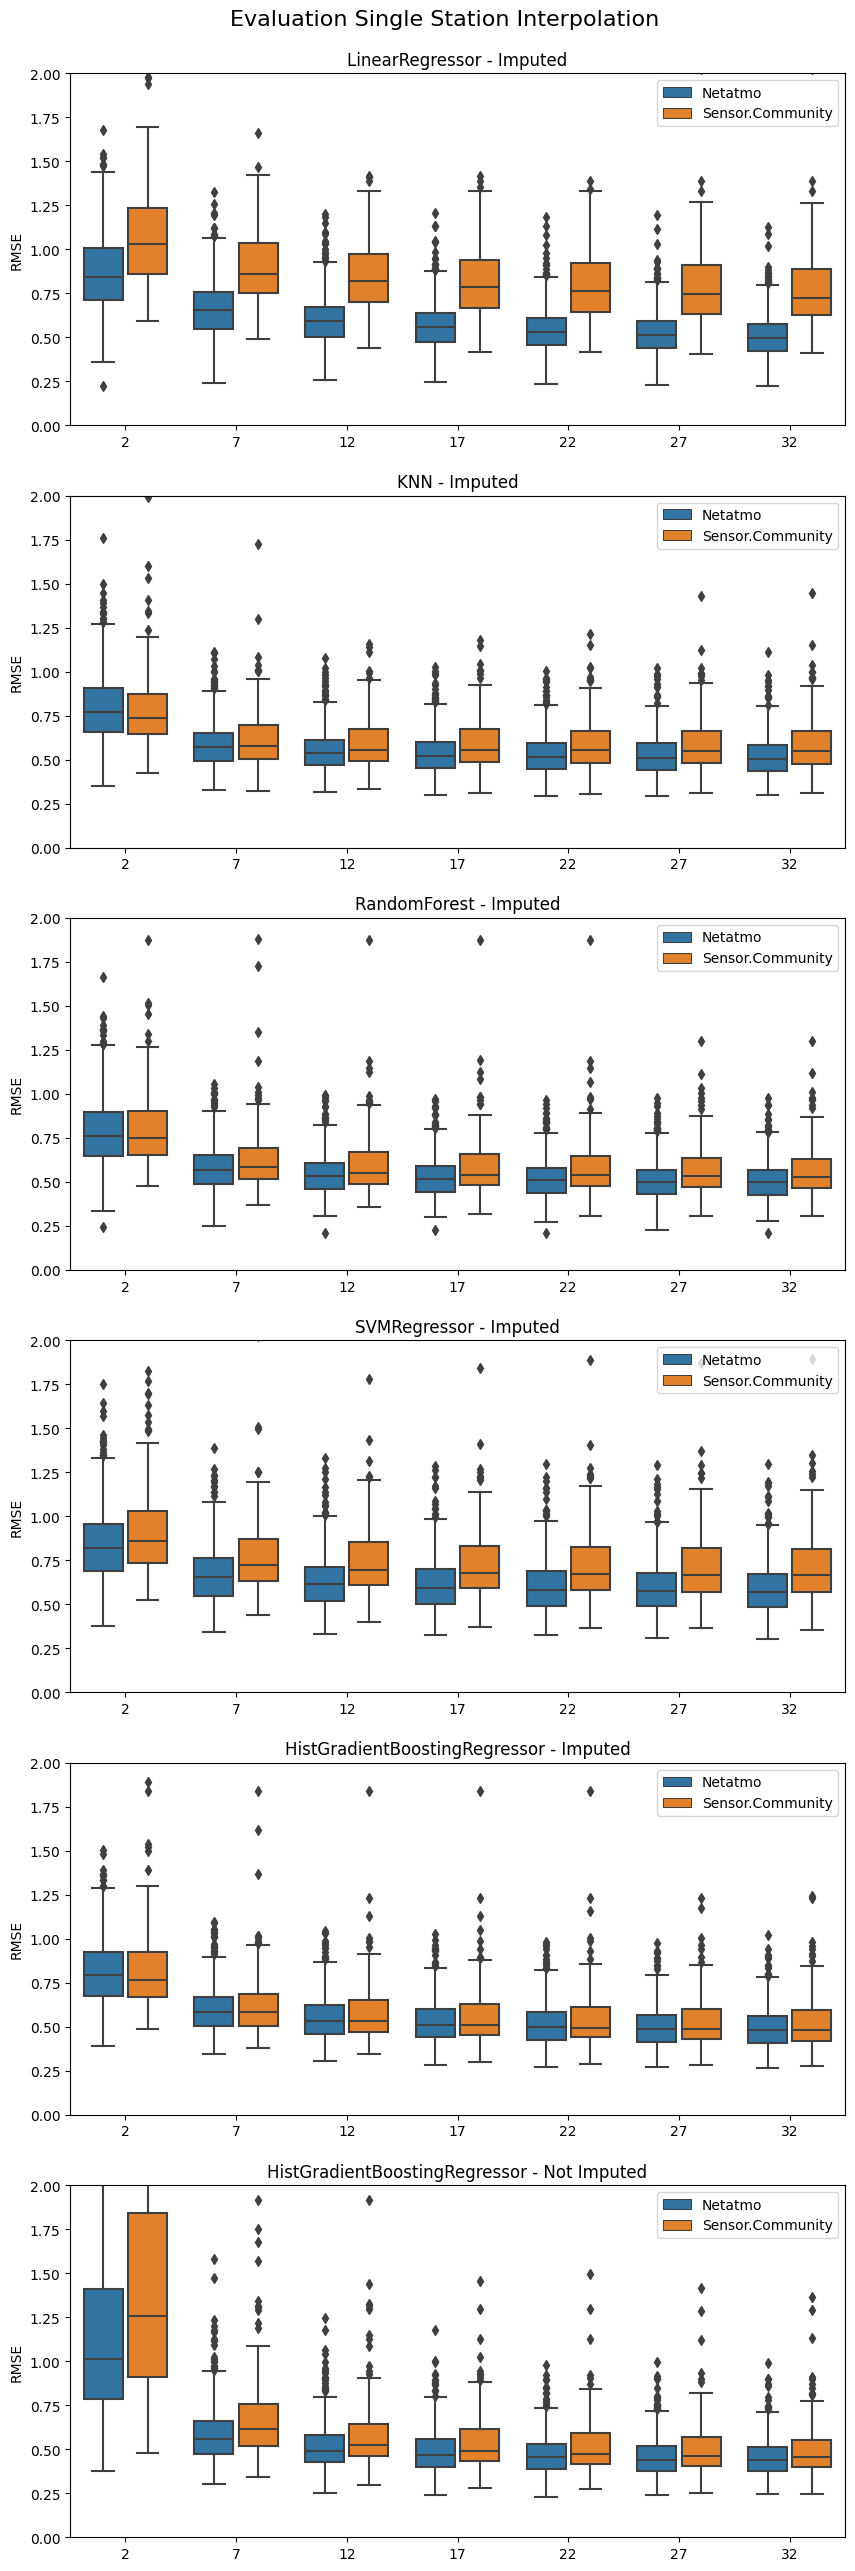

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Scatter plot of evaluation errors by number of neighbours
color_palette = sns.color_palette('tab10')

fig, axs = plt.subplots(6, 1, figsize=(10, 32))
fig.suptitle(F'Evaluation Single Station Interpolation', fontsize=16, y=0.90)

def plot_eval_for_regressor(regressor_type, is_imputed, ax):
    grouped_df = eval_df[(eval_df['regressor_type'] == regressor_type) & (eval_df['is_imputed'] == is_imputed)]

    # Set the 'hue' parameter in each lineplot call to differentiate the lines based on the 'hue' value
    sns.boxplot(data=grouped_df, x='n_neighbours', y='RMSE', hue="provider", ax=ax)

    ax.set_xlabel(None)
    ax.legend(loc='upper right')
    # ax[0].set_ybound()

for entry in [("LinearRegressor", True, 0), ("KNN", True, 1), ("RandomForest", True, 2), ("SVMRegressor", True, 3), ("HistGradientBoostingRegressor", True, 4), ("HistGradientBoostingRegressor", False, 5)]:
    regr_type = entry[0]
    is_imputed = entry[1]
    ax_idx = entry[2]
    ax = axs[ax_idx]

    ax.set_ylim(0, 2)

    if is_imputed:
        ax.set_title(f'{regr_type} - Imputed')
    else:
        ax.set_title(f'{regr_type} - Not Imputed')

    plot_eval_for_regressor(regr_type, is_imputed, ax)

axs[5]

adjust_box_widths(fig, 0.9)
plt.legend(loc='upper right')
plt.show()

# both into one subplot side by side
# legend - Netatmo Hamburg, Sensor.Community Stuttgart (two colors)




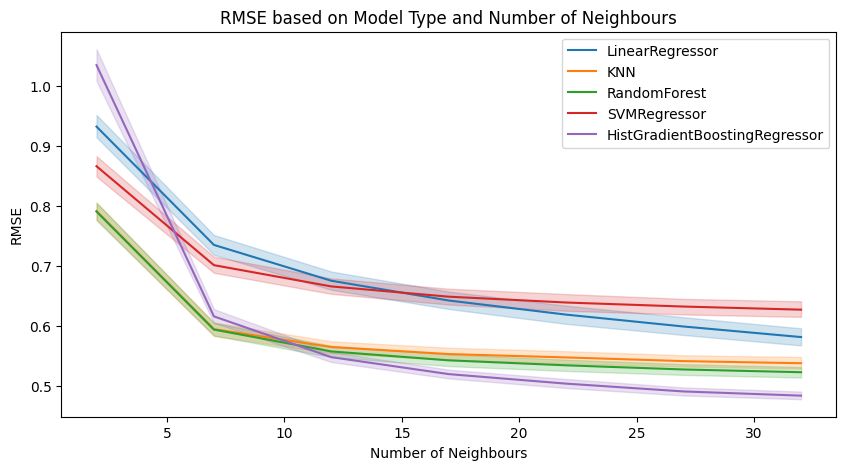

In [14]:
import seaborn as sns

# Define the color palette for the lines
color_palette = sns.color_palette('tab10')  # You can choose other palettes or define custom colors

fig, ax = plt.subplots(figsize=(10, 5))

grouped_df = eval_df

# Set the 'hue' parameter in each lineplot call to differentiate the lines based on the 'hue' value
sns.lineplot(data=grouped_df, x='n_neighbours', y='RMSE', ax=ax, hue="regressor_type", legend='auto', color=color_palette)

ax.set_title('RMSE based on Model Type and Number of Neighbours')
ax.legend(loc='upper right')
# axs[0].set_title('Mean Absolute Error')
ax.set_xlabel('Number of Neighbours')
# axs[0].set_ylabel('MAE')

plt.show()